In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sfusion import kalman as km

## Simulated Data

In [2]:
data = pd.read_csv('missing_gps_data.csv')

In [3]:
data.tail()

,Time,GPS_X,GPS_Y,GPS_Z,Accel_X,Accel_Y,Accel_Z,Gyro_X,Gyro_Y,Gyro_Z
1275,64.05,NaN,NaN,NaN,2.570687,-0.957358,9.810837,-0.002091,0.000572,-0.134616
1276,64.15,NaN,NaN,NaN,2.567233,-1.023922,9.804677,-0.002030,0.000009,-0.140303
1277,64.20,NaN,NaN,NaN,2.566792,-1.057948,9.798449,-0.002059,-0.000056,-0.143138
1278,64.25,NaN,NaN,NaN,2.566005,-1.092782,9.793209,-0.002120,0.000010,-0.145965
1279,64.30,NaN,NaN,NaN,2.564368,-1.128538,9.790168,-0.002197,0.000151,-0.148785


## 1. EKFGPSAccelerometerGyro2D

### 1.1. Raw Data Plot

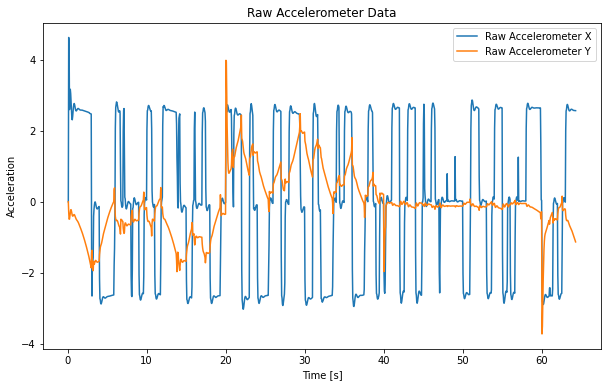

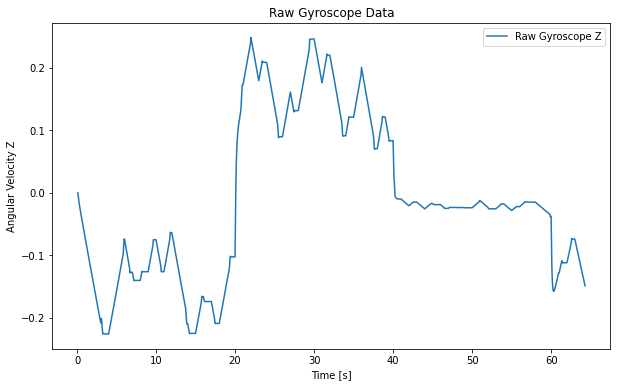

In [4]:
# Plot the raw accelerometer X and Y data
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], data['Accel_X'], label='Raw Accelerometer X', linestyle='-')
plt.plot(data['Time'], data['Accel_Y'], label='Raw Accelerometer Y', linestyle='-')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration')
plt.title('Raw Accelerometer Data')
plt.legend()
plt.show()

# Plot the raw gyroscope data
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], data['Gyro_Z'], label='Raw Gyroscope Z', linestyle='-')
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity Z')
plt.title('Raw Gyroscope Data')
plt.legend()
plt.show()

### 1.2. Sensor Fusion

In [5]:
# Initialize the Kalman filter for the x and y directions
initial_state = [data['GPS_X'].dropna().iloc[0], data['GPS_Y'].dropna().iloc[0], 0, 0, 0]  # initial positions, velocities, and orientation
initial_covariance = np.eye(5)
process_noise = np.eye(5) * 0.1
measurement_noise = np.eye(2) * 0.1

kf = km.EKFGPSAccelerometerGyro2D(initial_state, initial_covariance, process_noise, measurement_noise)

# Run the Kalman filter
fused_positions = []
fused_velocities = []
orientations = []

dt = 0.05  # Fixed time step of 50 milliseconds

for i in range(len(data)):
    acceleration = [data['Accel_X'].iloc[i], data['Accel_Y'].iloc[i]]
    angular_velocity = data['Gyro_Z'].iloc[i]
    kf.predict(dt=dt, control_input=[acceleration[0], acceleration[1], angular_velocity])
    
    if not np.isnan(data['GPS_X'].iloc[i]) and not np.isnan(data['GPS_Y'].iloc[i]):
        kf.update(measurement=[data['GPS_X'].iloc[i], data['GPS_Y'].iloc[i]])
    
    fused_positions.append(kf.state[:2])
    fused_velocities.append(kf.state[2:4])
    orientations.append(kf.state[4])

fused_positions = np.array(fused_positions)
fused_velocities = np.array(fused_velocities)
orientations = np.array(orientations)

### 1.3. Fused Data Plot

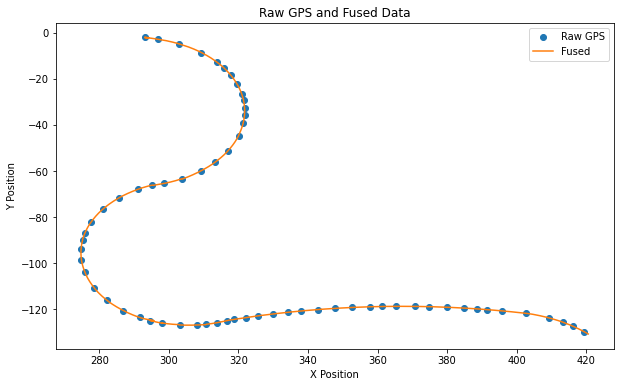

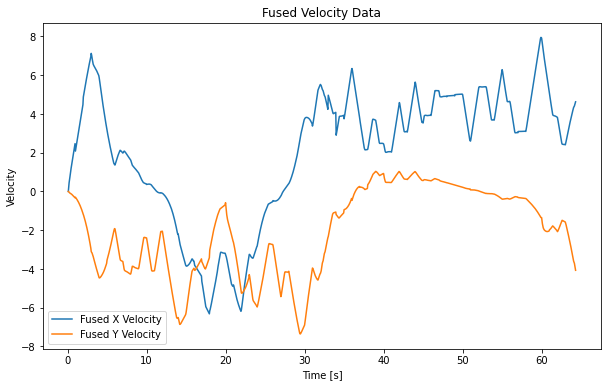

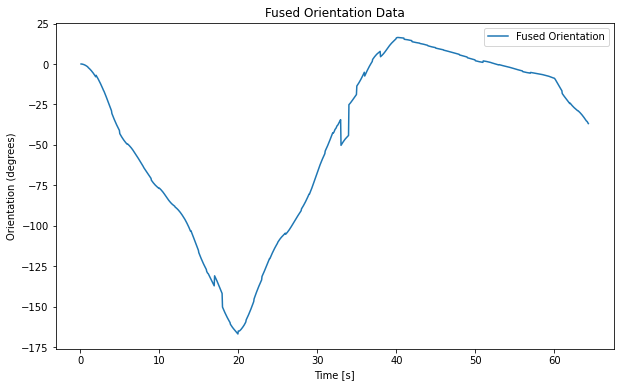

In [6]:
# Plot the fused trajectory data along with the raw GPS data
plt.figure(figsize=(10, 6))
plt.scatter(data['GPS_X'], data['GPS_Y'], label='Raw GPS')
plt.plot(fused_positions[:, 0], fused_positions[:, 1], label='Fused', linestyle='-', color='#ff7f0e')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Raw GPS and Fused Data')
plt.legend()
plt.show()

# Plot the fused velocity data
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], fused_velocities[:, 0], label='Fused X Velocity', linestyle='-')
plt.plot(data['Time'], fused_velocities[:, 1], label='Fused Y Velocity', linestyle='-')
plt.xlabel('Time [s]')
plt.ylabel('Velocity')
plt.title('Fused Velocity Data')
plt.legend()
plt.show()

# Convert orientation from radians to degrees
orientations_degrees = np.degrees(orientations)

# Plot the fused orientation data in degrees
plt.figure(figsize=(10, 6))
plt.plot(data['Time'], orientations_degrees, label='Fused Orientation', linestyle='-')
plt.xlabel('Time [s]')
plt.ylabel('Orientation (degrees)')
plt.title('Fused Orientation Data')
plt.legend()
plt.show()

### 1.4. Zoomed-in Plot

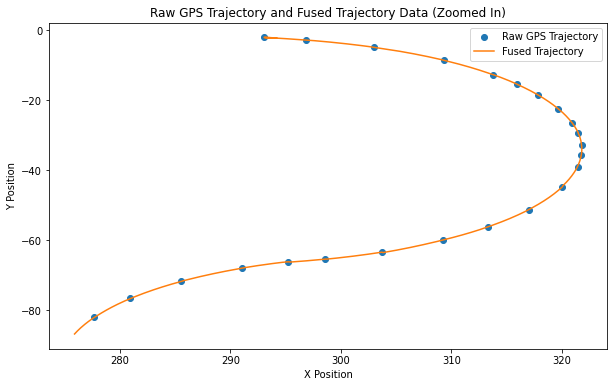

In [7]:
# Define the range you want to zoom in on (adjust indices based on your data)
start_time = 0
end_time = 25

# Convert times to the index range for the zoomed-in plot
start_index = data[data['Time'] >= start_time].index[0]
end_index = data[data['Time'] <= end_time].index[-1]

# Plot the fused data with zoom for the trajectory
plt.figure(figsize=(10, 6))
plt.scatter(data['GPS_X'][start_index:end_index], data['GPS_Y'][start_index:end_index], label='Raw GPS Trajectory')
plt.plot(fused_positions[start_index:end_index, 0], fused_positions[start_index:end_index, 1], label='Fused Trajectory', linestyle='-', color='#ff7f0e')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Raw GPS Trajectory and Fused Trajectory Data (Zoomed In)')
plt.legend()
plt.show()